In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
np.random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# **Importing necessary libraries!**

In [65]:
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import re

# **Defining Few Useful Functions!**

## **Money Convertion Function!**

In [66]:
def convert_money(money_str):
    try:
        multipliers = {'K': 1000, 'M': 1000000}
        amount = re.findall(r'\d+\.\d+|\d+', money_str)[0]
        multiplier = multipliers.get(money_str[-1], 1)
        return float(amount) * multiplier
    except Exception as e:
        #print(e)
        return money_str

## **Definig Model Training Function!**


In [67]:
def model_training(estimator, X_train, y_train):
    estimator.fit(X_train, y_train)

## **Model Evaluation Function!**

In [68]:
def model_evaluation(estimator, X_val, y_val):
    y_val_predict = estimator.predict(X_val)
    print(classification_report(y_val, y_val_predict))
    cm = confusion_matrix(y_val, y_val_predict)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    

# **Data Loading & Mining**

## Loading review training data from "train.csv" file

In [10]:
data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [11]:
data.shape

(162758, 5)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


## Loading data from "movies.csv" !

In [13]:
movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


## Checking any duplicate values in data!

In [14]:

data.duplicated().sum()

1118

## Removing duplicates values from data!

In [15]:
data_copy = data.drop_duplicates(ignore_index=True)

In [16]:
data_copy.shape

(161640, 5)

## Checking null values in movies data

In [17]:
movies.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

## Checking duplicates values in "movieid" column!

In [18]:

movies.duplicated(subset=["movieid"]).sum()

16854

## Dropping Duplicate "movieid" !

In [19]:
movies_copy = movies.drop_duplicates(subset=["movieid"], ignore_index=True)

In [20]:
movies_copy.shape

(126404, 14)



## Merging data and movies table to get our training data

In [21]:

merged_data = pd.merge(data_copy, movies_copy, how="inner", on=["movieid"]).reset_index(drop=True)

In [22]:

merged_data.shape

(161640, 18)

In [23]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161640 entries, 0 to 161639
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               161640 non-null  object 
 1   reviewerName          161640 non-null  object 
 2   isFrequentReviewer    161640 non-null  bool   
 3   reviewText            155243 non-null  object 
 4   sentiment             161640 non-null  object 
 5   title                 161640 non-null  object 
 6   audienceScore         148519 non-null  float64
 7   rating                98391 non-null   object 
 8   ratingContents        98391 non-null   object 
 9   releaseDateTheaters   126107 non-null  object 
 10  releaseDateStreaming  145615 non-null  object 
 11  runtimeMinutes        158275 non-null  float64
 12  genre                 159207 non-null  object 
 13  originalLanguage      158358 non-null  object 
 14  director              161640 non-null  object 
 15  

# **ML end to end Process on data with only "reviewText" as column!**

## **Data Preprocessing For Modeling on ReviewText Column!**

### Splitting data into features and targets variables!

In [69]:
new_df = merged_data.loc[:,["reviewText", "sentiment"]]

In [70]:
new_df = new_df.dropna()

In [71]:
new_df_X = new_df.loc[:,["reviewText"]].copy()
new_df_y = new_df["sentiment"].copy()

### Splitting data into train and validation dataset!

In [72]:
new_df_X_train, new_df_X_val, new_df_y_train, new_df_y_val = train_test_split(new_df_X, new_df_y, test_size=0.2, random_state = 42, stratify=new_df_y)

In [73]:
print("Training Data:", new_df_X_train.shape, "|", new_df_y_train.shape)
print("Training Data:", new_df_X_val.shape, "|", new_df_y_val.shape)

Training Data: (124194, 1) | (124194,)
Training Data: (31049, 1) | (31049,)


### Changing "reviewText" variable into numerical variable!

In [3]:
count_vect = CountVectorizer()

NameError: name 'CountVectorizer' is not defined

In [74]:
tfidf_vect = TfidfVectorizer()

In [75]:
new_df_X_train = tfidf_vect.fit_transform(new_df_X_train["reviewText"])

In [76]:
new_df_X_train.shape

(124194, 59952)

In [77]:
new_df_X_val = tfidf_vect.transform(new_df_X_val["reviewText"])

## **Building logistic Model!**

In [ ]:
log_reg = SGDClassifier(loss="log_loss", max_iter=100, random_state=42, penalty = "l2")

In [5]:
model_training(log_reg, new_df_X_train, new_df_y_train)

NameError: name 'model_training' is not defined

### Classification Report & Confusion Matrix on train data-set!

In [6]:
model_evaluation(log_reg, new_df_X_train, new_df_y_train)

NameError: name 'model_evaluation' is not defined

### Classification Report & Confusion Matrix on validation-set!

In [7]:
model_evaluation(log_reg, new_df_X_val, new_df_y_val)

NameError: name 'model_evaluation' is not defined

### **Hyperparameter Tuning!**

#### Setting parameter grid!

In [78]:
param_grid_log= {"alpha" :[1, 0.1, 0.01, 0.001, 0.0001, 0.00001], "learning_rate": ["constant", "optimal", "invscaling", "adaptive"]}

### Setting up estimator and initializing "GridSearchCV"!

In [40]:
logistic = SGDClassifier(loss="log_loss", max_iter=100, eta0 = 1, random_state=42, penalty = "l2")

In [41]:
gcv_log_reg = GridSearchCV(logistic, param_grid=param_grid_log, cv = 10)

#### Fitting data to "GridSearchCV"!

In [42]:
model_training(gcv_log_reg, new_df_X_train, new_df_y_train)

In [43]:
gcv_log_reg.cv_results_

{'mean_fit_time': array([14.62810051,  0.50278492,  0.58873298, 17.16965749,  0.71239264,
         0.49297636,  0.57004335,  2.94975593,  0.62065516,  0.55583291,
         0.58872025,  2.82405086,  0.57993755,  0.620327  ,  0.78187912,
         2.87639489,  0.71569474,  0.90103049,  1.30409086,  3.21789379,
         0.80150659,  1.72369716,  1.42683995,  3.08104177]),
 'std_fit_time': array([2.76622022, 0.00927273, 0.02274315, 2.71191965, 0.11123114,
        0.00512034, 0.01995804, 0.17925821, 0.14456296, 0.03617766,
        0.01326124, 0.18861815, 0.10364397, 0.01046019, 0.04650182,
        0.09204477, 0.10360286, 0.05760115, 0.11233149, 0.18284269,
        0.15320499, 0.17912033, 0.02606685, 0.16012191]),
 'mean_score_time': array([0.05098574, 0.04989259, 0.05016639, 0.0495625 , 0.05005031,
        0.05017824, 0.05016656, 0.04937372, 0.05189288, 0.05031614,
        0.04998326, 0.04997618, 0.04992688, 0.0510859 , 0.05088582,
        0.05245612, 0.0504802 , 0.05065215, 0.05074148, 0.05

In [44]:
gcv_log_reg.best_score_

0.8019631093544136

In [45]:
gcv_log_reg.best_estimator_

SGDClassifier(alpha=1e-05, eta0=1, learning_rate='adaptive', loss='log_loss',
              max_iter=100, random_state=42)

#### Classification Report & Confusion Matrix on train data-set!**

              precision    recall  f1-score   support

    NEGATIVE       0.87      0.78      0.82     40989
    POSITIVE       0.90      0.94      0.92     83205

    accuracy                           0.89    124194
   macro avg       0.88      0.86      0.87    124194
weighted avg       0.89      0.89      0.89    124194



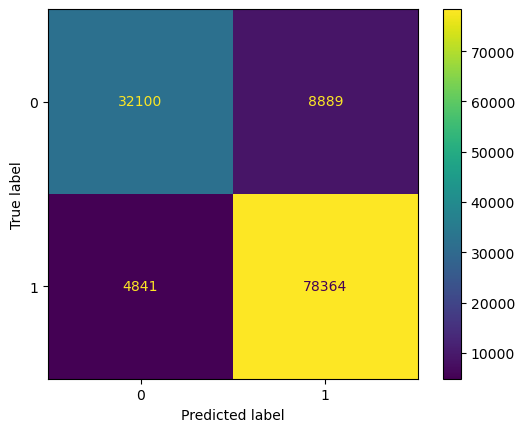

In [46]:
model_evaluation(gcv_log_reg.best_estimator_, new_df_X_train, new_df_y_train)

#### Classification Report & Confusion Matrix on validation set!

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.65      0.69     10248
    POSITIVE       0.84      0.88      0.86     20801

    accuracy                           0.81     31049
   macro avg       0.79      0.77      0.77     31049
weighted avg       0.80      0.81      0.80     31049



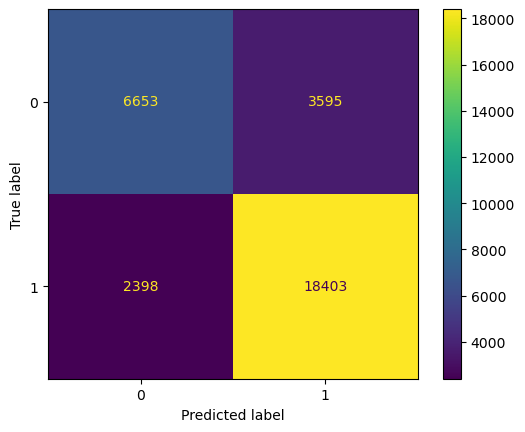

In [47]:
model_evaluation(gcv_log_reg.best_estimator_, new_df_X_val, new_df_y_val)

## **Building SVM Model!**

In [79]:
s_v_m = SGDClassifier(loss = "hinge", max_iter = 100, random_state = 42)

In [80]:
model_training(s_v_m, new_df_X_train, new_df_y_train)

### Classification Report & Confusion Matrix on train dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.40      0.55     40989
    POSITIVE       0.77      0.97      0.85     83205

    accuracy                           0.78    124194
   macro avg       0.81      0.68      0.70    124194
weighted avg       0.79      0.78      0.75    124194



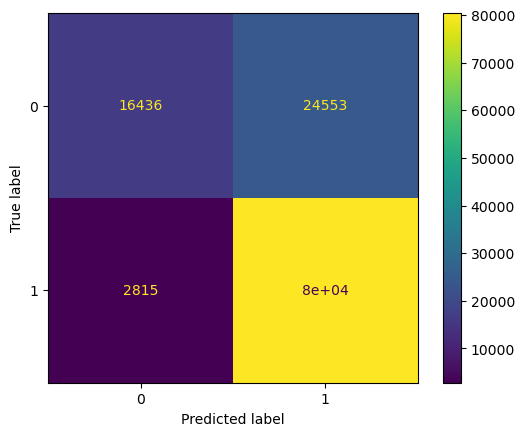

In [81]:
model_evaluation(s_v_m, new_df_X_train, new_df_y_train)

### Classification Report & Confusion Matrix on validation set!

              precision    recall  f1-score   support

    NEGATIVE       0.83      0.37      0.51     10248
    POSITIVE       0.76      0.96      0.85     20801

    accuracy                           0.77     31049
   macro avg       0.79      0.67      0.68     31049
weighted avg       0.78      0.77      0.74     31049



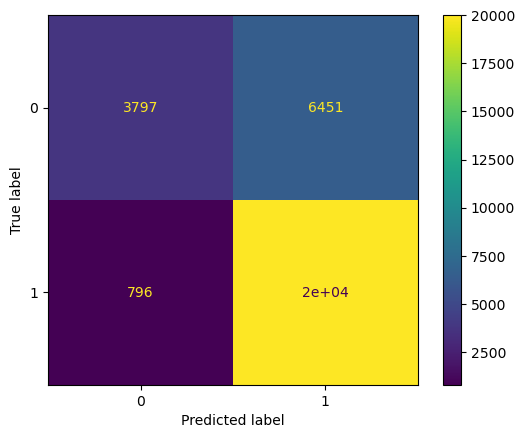

In [82]:
model_evaluation(s_v_m, new_df_X_val, new_df_y_val)

### **Hyper-parameter tuning!**

#### Setting up parameter grid!

In [90]:
param_grid_svm = {"alpha" :[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], "learning_rate": ["constant", "optimal", "invscaling", "adaptive"]}

#### Initializing estimator and GridSearchCV

In [91]:
svm_ = SGDClassifier(loss = "hinge", max_iter = 100, random_state = 42, eta0 = 1)

In [92]:
gcv_svm = GridSearchCV(svm_, param_grid=param_grid_svm, cv = 5)

#### Fitting train data to GridSearchCV

In [93]:
model_training(gcv_svm, new_df_X_train, new_df_y_train)

In [94]:
gcv_svm.best_estimator_

SGDClassifier(alpha=1e-05, eta0=1, learning_rate='adaptive', max_iter=100,
              random_state=42)

#### Classification Report and Confusion Matrix on train data-set!

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.72      0.78     40989
    POSITIVE       0.87      0.94      0.90     83205

    accuracy                           0.87    124194
   macro avg       0.86      0.83      0.84    124194
weighted avg       0.87      0.87      0.86    124194



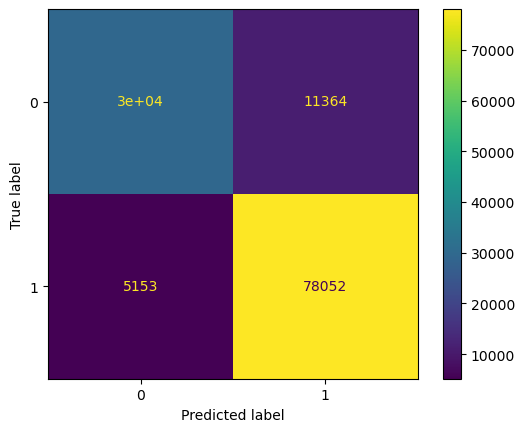

In [95]:
model_evaluation(gcv_svm.best_estimator_, new_df_X_train, new_df_y_train)

#### Classification Rreport & Confusion Matrix on validation dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.63      0.69     10248
    POSITIVE       0.83      0.90      0.86     20801

    accuracy                           0.81     31049
   macro avg       0.79      0.76      0.78     31049
weighted avg       0.81      0.81      0.81     31049



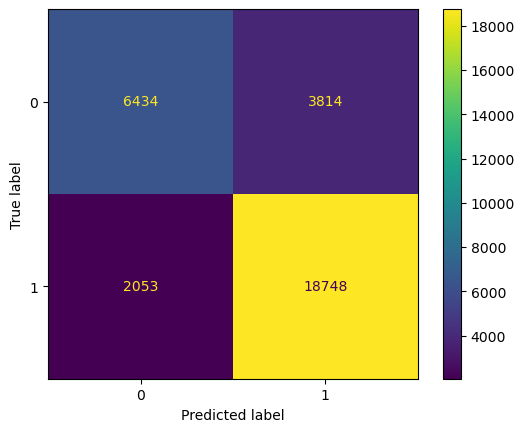

In [96]:
model_evaluation(gcv_svm.best_estimator_, new_df_X_val, new_df_y_val)

## **Building "MultinomialNB" Model!**

In [61]:
m_n_b = MultinomialNB()

In [62]:
model_training(m_n_b, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on train dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77     40989
    POSITIVE       0.89      0.89      0.89     83205

    accuracy                           0.85    124194
   macro avg       0.83      0.83      0.83    124194
weighted avg       0.85      0.85      0.85    124194



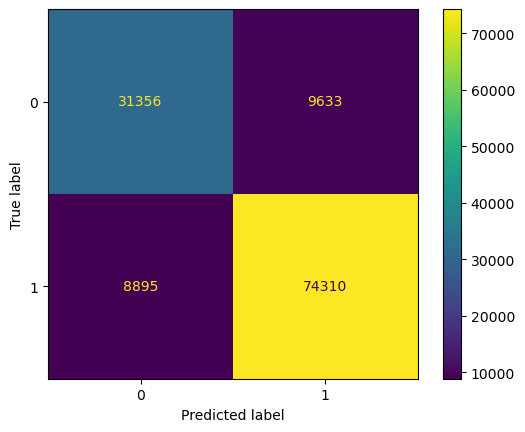

In [63]:
model_evaluation(m_n_b, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on validation dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.72      0.67      0.69     10248
    POSITIVE       0.84      0.87      0.86     20801

    accuracy                           0.80     31049
   macro avg       0.78      0.77      0.77     31049
weighted avg       0.80      0.80      0.80     31049



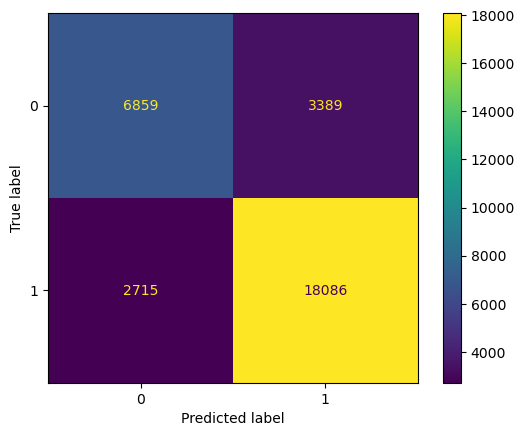

In [64]:
model_evaluation(m_n_b, new_df_X_val, new_df_y_val)

## **Building MLP Classifier Model!**

### Initiating MLP Classifier!

In [94]:
mlp = MLPClassifier(hidden_layer_sizes = (3,3), alpha = .1, learning_rate="adaptive")

### Trainig MLP Classifier!

In [95]:
model_training(mlp, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on training Dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.96      0.97      0.96     40989
    POSITIVE       0.99      0.98      0.98     83205

    accuracy                           0.98    124194
   macro avg       0.97      0.97      0.97    124194
weighted avg       0.98      0.98      0.98    124194



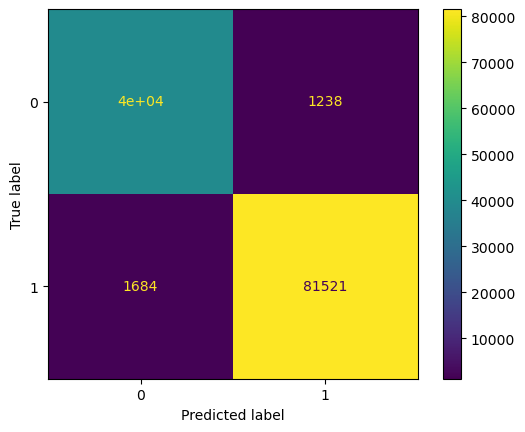

In [96]:
model_evaluation(mlp, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on validation dataset!

              precision    recall  f1-score   support

    NEGATIVE       0.63      0.65      0.64     10248
    POSITIVE       0.83      0.81      0.82     20801

    accuracy                           0.76     31049
   macro avg       0.73      0.73      0.73     31049
weighted avg       0.76      0.76      0.76     31049



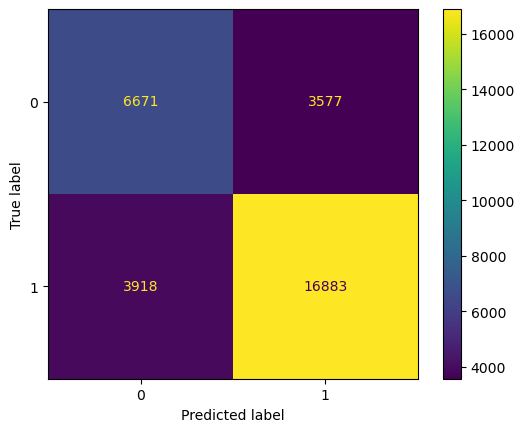

In [97]:
model_evaluation(mlp, new_df_X_val, new_df_y_val)

## **Building AdaBoostClassfier!**

In [77]:
abc_ = AdaBoostClassifier(random_state = 42)

In [78]:
model_training(abc_, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on Train Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.66      0.24      0.35     40989
    POSITIVE       0.72      0.94      0.81     83205

    accuracy                           0.71    124194
   macro avg       0.69      0.59      0.58    124194
weighted avg       0.70      0.71      0.66    124194



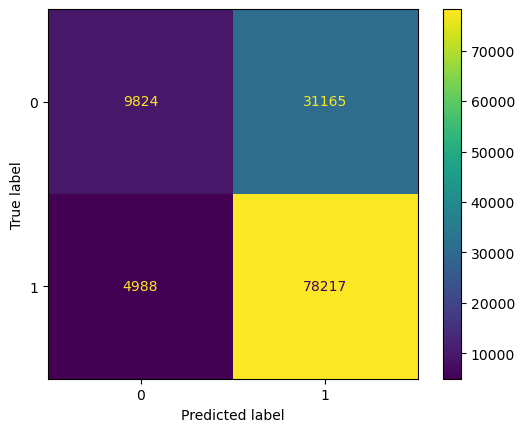

In [79]:
model_evaluation(abc_, new_df_X_train, new_df_y_train)

### Classification Report and Confusion Matrix on Validation Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.66      0.24      0.35     10248
    POSITIVE       0.71      0.94      0.81     20801

    accuracy                           0.71     31049
   macro avg       0.69      0.59      0.58     31049
weighted avg       0.70      0.71      0.66     31049



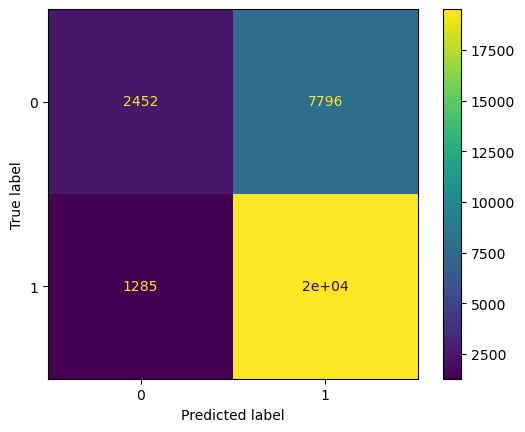

In [80]:
model_evaluation(abc_, new_df_X_val, new_df_y_val)

# **ML End to End Process on Data having few more columns and less rows(We are sampling data from population) Column!**

## **Data Preprocessing**

### Taking out data having null value in "reviewText" column!

In [24]:
df, temp = train_test_split(merged_data, train_size=45000, random_state=42, stratify=merged_data["sentiment"])

In [25]:
df.shape

(45000, 18)

### Taking out features that seem important and target variable!

In [26]:
df_X = df.loc[:,["isFrequentReviewer", "audienceScore", "rating", "runtimeMinutes", "genre", "originalLanguage", "boxOffice", "distributor", "reviewText"]].copy()
df_y = df.loc[:,["sentiment"]].copy()

In [27]:
df_X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 105526 to 22021
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isFrequentReviewer  45000 non-null  bool   
 1   audienceScore       41407 non-null  float64
 2   rating              27462 non-null  object 
 3   runtimeMinutes      44054 non-null  float64
 4   genre               44315 non-null  object 
 5   originalLanguage    44078 non-null  object 
 6   boxOffice           30272 non-null  object 
 7   distributor         33728 non-null  object 
 8   reviewText          43199 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 3.1+ MB


### Splitting the newly created dataset into train and validation set!

In [28]:
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_X, df_y, train_size = 0.80, random_state = 42, stratify = df_y)

In [29]:
df_y_train = np.array(df_y_train).reshape((df_y_train.shape[0],))
df_y_val = np.array(df_y_val).reshape((df_y_val.shape[0],))

### Changing the "boxOffice" variable to float number!

In [30]:
df_X_train["boxOffice"] = df_X_train["boxOffice"].astype("str")
df_X_val["boxOffice"] = df_X_val["boxOffice"].astype("str")
##Should change wtih "str"

In [31]:
print(convert_money("$12.7M"))

12700000.0


In [32]:
df_X_train["boxOffice"] = df_X_train["boxOffice"].apply(convert_money)
df_X_val["boxOffice"] = df_X_val["boxOffice"].apply(convert_money)

In [33]:
df_X_train["boxOffice"].head()

133997     20300000.0
111938            nan
63420             nan
86206     104100000.0
108849     37700000.0
Name: boxOffice, dtype: object

In [34]:
df_X_train["boxOffice"] = df_X_train["boxOffice"].astype(float)
df_X_val["boxOffice"] = df_X_val["boxOffice"].astype(float)

### Changing the dtype of all variable which has dtype as object to category!

In [35]:
for col in df_X_train.columns:
    if df_X_train[col].dtypes == "object" and col != "reviewText" and col != "genre":
        print(df_X_train[col].dtypes)
        df_X_train[col] = df_X_train[col].astype("category")
    elif col == "reviewText" or col == "genre":
        print(df_X_train[col].dtypes)
        df_X_train[col] = df_X_train[col].astype("str")

object
object
object
object
object


In [36]:
for col in df_X_val.columns:
    if df_X_val[col].dtypes == "object" and col != "reviewText" and col != "genre":
        print(df_X_val[col].dtypes)
        df_X_val[col] = df_X_val[col].astype("category")
    elif col == "reviewText" or col == "genre":
        print(df_X_val[col].dtypes)
        df_X_val[col] = df_X_val[col].astype("str")

object
object
object
object
object


In [37]:
df_X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 134336 to 119236
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   isFrequentReviewer  9000 non-null   bool    
 1   audienceScore       8269 non-null   float64 
 2   rating              5504 non-null   category
 3   runtimeMinutes      8818 non-null   float64 
 4   genre               9000 non-null   object  
 5   originalLanguage    8820 non-null   category
 6   boxOffice           6053 non-null   float64 
 7   distributor         6759 non-null   category
 8   reviewText          9000 non-null   object  
dtypes: bool(1), category(3), float64(3), object(2)
memory usage: 490.4+ KB


In [38]:
df_X_train["isFrequentReviewer"].replace({True:1, False:0}, inplace=True)
df_X_val["isFrequentReviewer"].replace({True:1, False:0}, inplace=True)

### Setting up the transformers that we are going to apply on numerical columns!

In [39]:
num_pipe = [("sim_imp", SimpleImputer()), ("mms", MinMaxScaler())]
num_pipeline = Pipeline(steps=num_pipe)

### Setting up the transformers for categorical variable except "genre" and "reviewText" variable!

In [40]:
cat_pipe_1 = [("sim_imp_cat1", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(sparse_output=False, drop="first", handle_unknown='ignore'))]

In [41]:
cat_pipeline_1 = Pipeline(steps = cat_pipe_1)

### Now Merging numerical pipeline and categorical pipeline into one column transformer!

In [42]:
transformers = [("num_trans", num_pipeline, ["audienceScore", "runtimeMinutes", "boxOffice"]),
                ("cat_trans", cat_pipeline_1, ["rating", "originalLanguage", "distributor"])]
colum_trans = ColumnTransformer(transformers = transformers, remainder="drop")

### Fitting and transforming our feature data using transformers that we have defined!

In [43]:
df_X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 134336 to 119236
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   isFrequentReviewer  9000 non-null   int64   
 1   audienceScore       8269 non-null   float64 
 2   rating              5504 non-null   category
 3   runtimeMinutes      8818 non-null   float64 
 4   genre               9000 non-null   object  
 5   originalLanguage    8820 non-null   category
 6   boxOffice           6053 non-null   float64 
 7   distributor         6759 non-null   category
 8   reviewText          9000 non-null   object  
dtypes: category(3), float64(3), int64(1), object(2)
memory usage: 551.9+ KB


In [44]:
df_X_train_1 = colum_trans.fit_transform(df_X_train)
df_X_val_1 = colum_trans.transform(df_X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
df_X_train_1.shape

(36000, 1309)

### Setting up transformers and fitting for changing "genre" column into numerical dtype!

#### Setting up Imputer first and imputing most frequent value in "genre" column!

In [46]:
sim_imp_cat2 = SimpleImputer(strategy="most_frequent")

In [47]:
df_X_train["genre"] = sim_imp_cat2.fit_transform(df_X_train.loc[:, ["genre"]])
df_X_val["genre"] = sim_imp_cat2.transform(df_X_val.loc[:, ["genre"]])

#### Setting up countvectorizer to change "genre" column into "numerical" type!

In [48]:
cv_genre = CountVectorizer()

In [49]:
df_X_train_2 = cv_genre.fit_transform(df_X_train.loc[:,"genre"])
df_X_val_2 = cv_genre.transform(df_X_val.loc[:, "genre"])

In [50]:
df_X_train_2 = df_X_train_2.toarray()
df_X_val_2 = df_X_val_2.toarray()

### Setting up transformers and fitting "reviewText" column to change it into numerical dtype!

#### Filling "nan" values to "" in "reviewText" column

In [51]:
df_X_train["reviewText"] = df_X_train["reviewText"].fillna("")
df_X_val["reviewText"] = df_X_val["reviewText"].fillna("")

#### Setting up CountVectorizer to change "reviewText" column into numerical type!

In [104]:
cv_reviewText = CountVectorizer()

In [53]:
df_X_train_3 = cv_reviewText.fit_transform(df_X_train.loc[:, "reviewText"])
df_X_val_3 = cv_reviewText.transform(df_X_val.loc[:, "reviewText"])

In [54]:
df_X_train_3 = df_X_train_3.toarray()
df_X_val_3 = df_X_val_3.toarray()

### Concatenating different array to get a consolidate feature data set!

In [55]:
df_X_train_new = np.concatenate((np.array(df_X_train["isFrequentReviewer"]).reshape(-1,1), df_X_train_1, df_X_train_2, df_X_train_3), axis=1)
df_X_train_new.shape

(36000, 37921)

In [56]:
df_X_val_new = np.concatenate((np.array(df_X_val["isFrequentReviewer"]).reshape(-1,1), df_X_val_1, df_X_val_2, df_X_val_3), axis=1)
df_X_val_new.shape

(9000, 37921)

In [53]:
#df_y_train_new = np.array(df_y_train[:10000].copy()).reshape((10000,))
#df_y_val_new = np.array(df_y_val[:2000].copy()).reshape((2000,))

## **Building Logistic Model!**

In [60]:
log_reg_more = SGDClassifier(loss="log_loss", max_iter=100, random_state=42, penalty = "l2", eta0 = 1, learning_rate = "adaptive", alpha = 0.00001)

In [61]:
model_training(log_reg_more, df_X_train_new, df_y_train)

### Classfication Report and Confusion Matrix on Train Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.96      0.93      0.95     11943
    POSITIVE       0.97      0.98      0.97     24057

    accuracy                           0.97     36000
   macro avg       0.96      0.96      0.96     36000
weighted avg       0.97      0.97      0.97     36000



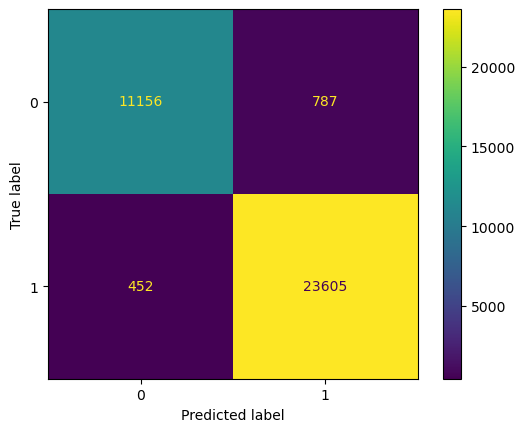

In [63]:
model_evaluation(log_reg_more, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Validation Dat Set!

              precision    recall  f1-score   support

    NEGATIVE       0.69      0.62      0.65      2986
    POSITIVE       0.82      0.86      0.84      6014

    accuracy                           0.78      9000
   macro avg       0.76      0.74      0.75      9000
weighted avg       0.78      0.78      0.78      9000



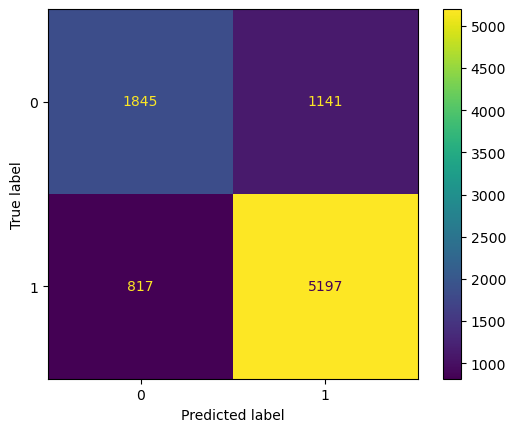

In [65]:
model_evaluation(log_reg_more, df_X_val_new, df_y_val)

### **Hper-parameter Tuning!**

#### Setting up parameter grid!

In [57]:
param_grid_logistic_more = {"alpha" :[0.01,0.001, 0.0001, 0.00001], "learning_rate":  ["adaptive"]}

#### Setting up GridSearchCV!

In [58]:
gcv_logsitic_more = GridSearchCV(SGDClassifier(loss="log_loss",max_iter = 5, eta0 = 1, random_state = 42), param_grid = param_grid_logistic_more, cv = 5)

#### Training the model!

In [59]:
model_training(gcv_logsitic_more, df_X_train_new, df_y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

In [62]:
gcv_logsitic_more.best_estimator_

SGDClassifier(alpha=1e-05, eta0=1, learning_rate='adaptive', loss='log_loss',
              max_iter=5, random_state=42)

#### **Classification Report on Training Dataset using Best Estimator from "GridSearchCV"!****

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.43      0.57     11943
    POSITIVE       0.77      0.96      0.86     24057

    accuracy                           0.79     36000
   macro avg       0.82      0.70      0.72     36000
weighted avg       0.80      0.79      0.76     36000



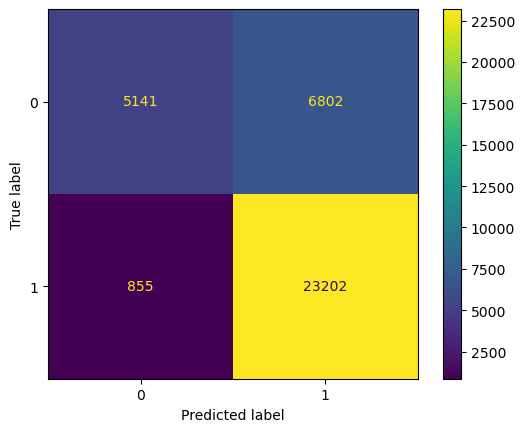

In [61]:
model_evaluation(gcv_logsitic_more.best_estimator_, df_X_train_new, df_y_train)

#### **Classification Report on Validation Dataset Using Best Estimator from "GridSearchCV"!**

In [ ]:
model_evaluation(gcv_logsitic_more.best_estimator_, df_X_val_new, df_y_val)

## **Building SVM Model!**

In [114]:
svm_more = SGDClassifier(loss="hinge", max_iter=2, random_state=42, penalty = "l2", learning_rate="adaptive", eta0=1, alpha=0.0001)

In [115]:
model_training(svm_more, df_X_train_new, df_y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Classification Report and Confusion Matrix on Train Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.95      0.84      0.89      2654
    POSITIVE       0.92      0.98      0.95      5346

    accuracy                           0.93      8000
   macro avg       0.94      0.91      0.92      8000
weighted avg       0.93      0.93      0.93      8000



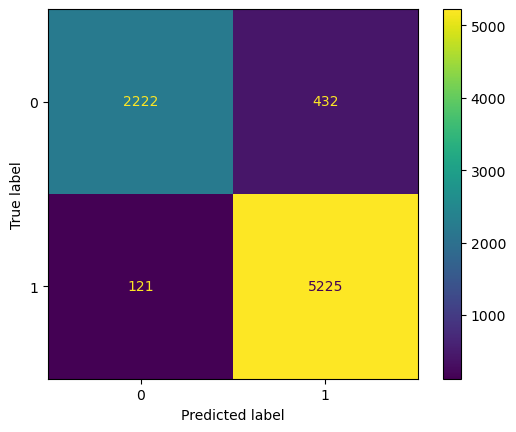

In [116]:
model_evaluation(svm_more, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Validation Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.37      0.28      0.32       671
    POSITIVE       0.68      0.76      0.71      1329

    accuracy                           0.60      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.57      0.60      0.58      2000



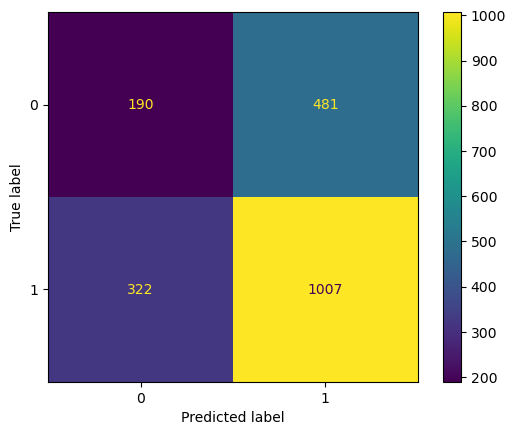

In [117]:
model_evaluation(svm_more, df_X_val_new, df_y_val)

### **Hyper-Parameter Tuning!**

#### Setting up Parameter grid!

In [105]:
param_grid_svm_more = {"alpha": [0.01, 0.001, 0.00001], "learning_rate": ["adaptive"]}

#### Intializing GridSearchCV

In [107]:
gcv_svm_more = GridSearchCV(SGDClassifier(loss="hinge", max_iter = 10, random_state = 42, eta0 = 1), param_grid = param_grid_svm_more, cv = 5)

#### Training the Model!

In [108]:
model_training(gcv_svm_more, df_X_train_new, df_y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

#### **Classification Report on Training Dataset using Best Estimator!**

              precision    recall  f1-score   support

    NEGATIVE       0.58      0.86      0.69     11943
    POSITIVE       0.91      0.69      0.79     24057

    accuracy                           0.75     36000
   macro avg       0.75      0.78      0.74     36000
weighted avg       0.80      0.75      0.76     36000



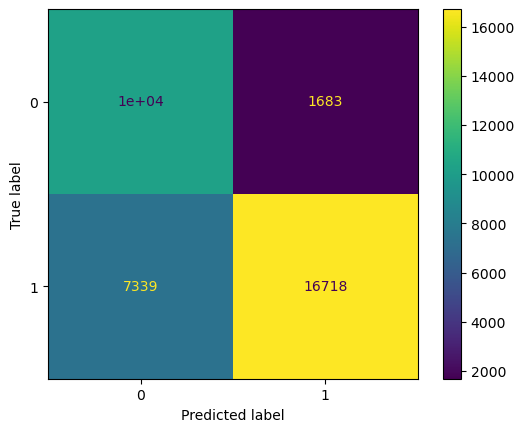

In [110]:
model_evaluation(gcv_svm_more.best_estimator_, df_X_train_new, df_y_train)

#### **Classfication Report on Validation Dataset using Best Estimator!**

              precision    recall  f1-score   support

    NEGATIVE       0.53      0.77      0.62      2986
    POSITIVE       0.85      0.66      0.74      6014

    accuracy                           0.69      9000
   macro avg       0.69      0.71      0.68      9000
weighted avg       0.74      0.69      0.70      9000



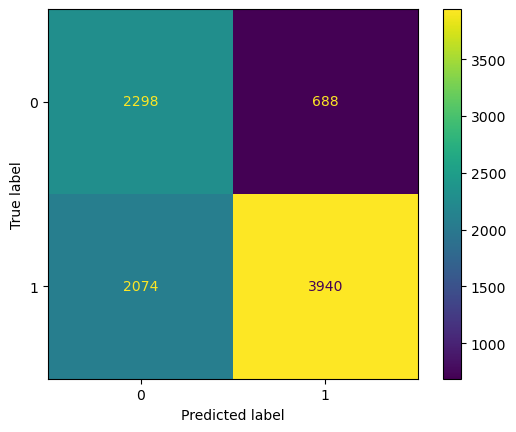

In [111]:
model_evaluation(gcv_svm_more.best_estimator_, df_X_val_new, df_y_val)

## **Building Multinomial Model!**

In [112]:
mnb_more = MultinomialNB()

In [113]:
model_training(mnb_more, df_X_train_new, df_y_train)

### Classification Report and Confusion Matirx on Train Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.84      0.77      0.80     11943
    POSITIVE       0.89      0.92      0.91     24057

    accuracy                           0.87     36000
   macro avg       0.86      0.85      0.85     36000
weighted avg       0.87      0.87      0.87     36000



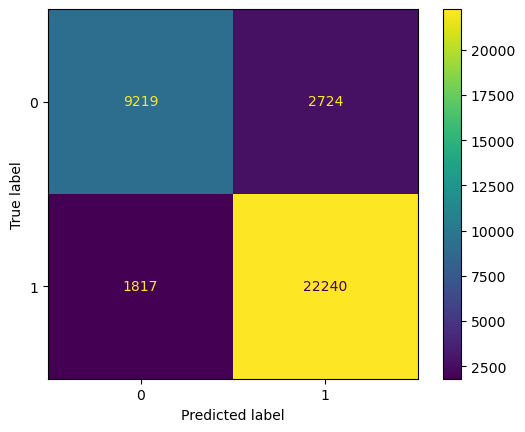

In [114]:
model_evaluation(mnb_more, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Validation Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.71      0.58      0.64      2986
    POSITIVE       0.81      0.88      0.84      6014

    accuracy                           0.78      9000
   macro avg       0.76      0.73      0.74      9000
weighted avg       0.78      0.78      0.78      9000



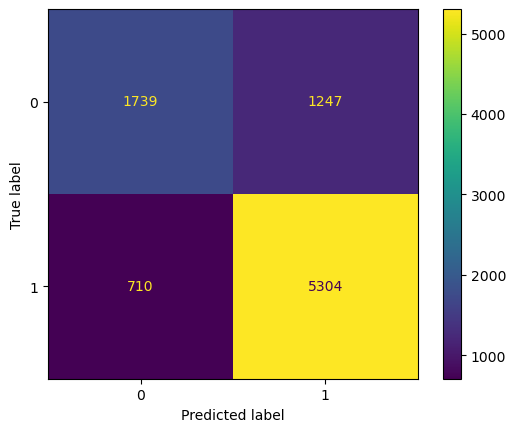

In [115]:
model_evaluation(mnb_more, df_X_val_new, df_y_val)

## **Building KNN Algorithm!**

In [116]:
knn = KNeighborsClassifier()

### **Hyper-Parameter Tuning**

In [120]:
param_grid = {"n_neighbors": [3,5,7]}

In [121]:
gcv_knn_more = GridSearchCV(knn, param_grid=param_grid, cv = 5)

In [ ]:
model_training(gcv_knn_more, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Train Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.71      0.49      0.58      2654
    POSITIVE       0.78      0.90      0.84      5346

    accuracy                           0.76      8000
   macro avg       0.75      0.70      0.71      8000
weighted avg       0.76      0.76      0.75      8000



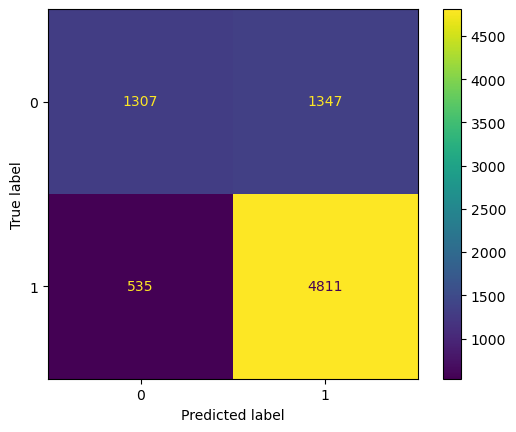

In [135]:
model_evaluation(gcv_knn_more.best_estimator_, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Validation Data Set!

              precision    recall  f1-score   support

    NEGATIVE       0.45      0.33      0.38       664
    POSITIVE       0.71      0.80      0.75      1336

    accuracy                           0.64      2000
   macro avg       0.58      0.56      0.57      2000
weighted avg       0.62      0.64      0.63      2000



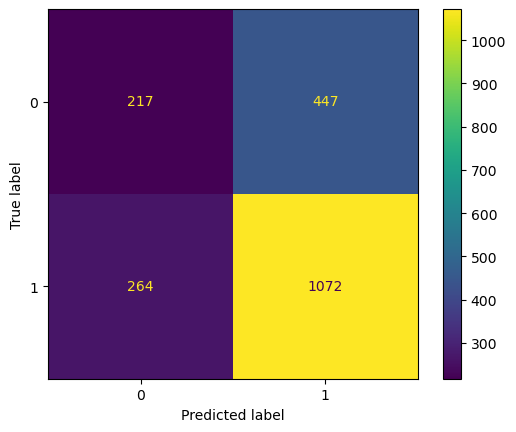

In [136]:
model_evaluation(gcv_knn_more.best_estimator_, df_X_val_new, df_y_val)

## **Building AdaBoostClassifier!**

In [ ]:
abc_nrt = AdaBoostClassifier(random_state = 42)

In [ ]:
model_training(abc, df_X_train_new, df_y_train)

### Classification Report and Confusion Matrix on Train Data Set!

In [ ]:
model_evaluation(abc, df_X_train, df_y_train)

### Classification Report and Confusion Matrix on Train Data Set!

In [ ]:
model_evaluation(abc, df_X_val_new, df_y_val)

# **Prediction on Test Data Set Using the Best Model!**

## Loading the test Data Set from "test.csv"

In [98]:
test_df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

## **Data Preprocessing**

In [99]:
merged_test_data = pd.merge(test_df, movies_copy, how="inner", on=["movieid"]).reset_index(drop=True)

In [100]:
X_test = merged_test_data.loc[:,["reviewText"]].copy()

In [101]:
X_test = tfidf_vect.transform(X_test)

## **Making Prediction**

In [102]:
y_test_pred = gcv_svm.best_estimator_.predict(X_test)

### Saving Prediction to "submission.csv"

In [103]:
y_test_pred = pd.DataFrame(y_test_pred, columns=["sentiment"])
y_test_pred.to_csv("submission.csv", index_label="id")